<a href="https://colab.research.google.com/github/SabaSaeed4/Deep-learning-practice/blob/main/BR_using_transfer_learningipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from PIL import  Image
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import EfficientNetB0
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from IPython.display import display,clear_output

In [3]:
labels = ['yes', 'no']

In [4]:
X_train = []
y_train = []
IMG_SIZE = 256
for i in labels:
  folder_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/images/Brain-Tumor/brain tumor/brain_tumor_dataset',i)
  for j in tqdm(os.listdir(folder_path)):
    img = cv2.imread(os.path.join(folder_path,j))
    try:
      face = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    except:
        break
    face = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    (b, g, r)=cv2.split(face)
    img=cv2.merge([r,g,b])
    X_train.append(img)
    y_train.append(i)

100%|██████████| 98/98 [01:04<00:00,  1.52it/s]


In [5]:
len(X_train)

253

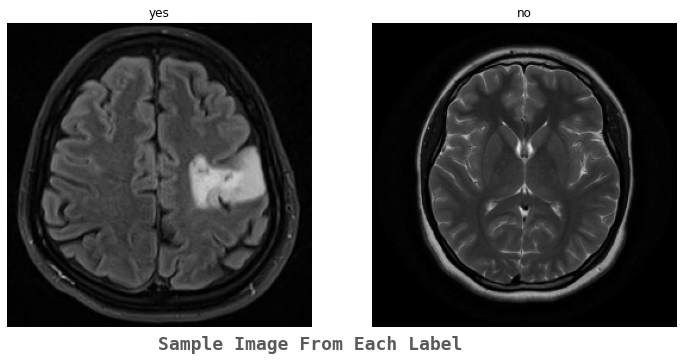

In [6]:
k=0
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
fig, ax = plt.subplots(1,2,figsize=(12,12))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.3,x=0.3,alpha=0.8)
for i in labels:
    j=0
    while True :
      if y_train[j]==i:
        ax[k].imshow(X_train[j])
        ax[k].set_title(y_train[j])
        ax[k].axis('off')
        k+=1
        break
      j+=1

In [7]:
X_train, y_train = shuffle(X_train, y_train, random_state=101)

In [8]:
np.array(X_train).shape

(253, 256, 256, 3)

In [9]:
y = [labels.index(i) for i in y_train]

In [10]:
len(y_train)

253

In [19]:
X_train = np.array(X_train)
y_train = np.array(y)

In [12]:
X_train.shape, y_train.shape

((253, 256, 256, 3), (253,))

In [13]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y, test_size=0.1,random_state=101)

In [14]:
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip(
        "horizontal",
        input_shape = (IMG_SIZE,IMG_SIZE, 3)
    ),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
])

In [25]:
model = tf.keras.models.Sequential([
    data_augmentation,
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256, 256, 3)),
    tf.keras.layers.experimental.preprocessing.Resizing(256,256),
    
    tf.keras.layers.Conv2D(64, (3,3), input_shape=(256,256,3) , padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.25),

    # 512 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='softmax')
    ])

In [26]:
adam = tf.keras.optimizers.Adam(lr=0.01, decay=1e-6)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate= 1e-2,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
model.compile(
    loss='categorical_crossentropy', 
    optimizer= 'adam', 
    metrics=['accuracy']
)

In [27]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if logs.get('accuracy') is not None and logs.get('accuracy') > 0.985:
      print("\n reached 98.5% accuracy so canceling training!")
      self.model.stop_training=True

In [28]:
epochs = 50
filepath = '/content/drive/MyDrive/Colab Notebooks/images/Brain-Tumor/brain tumor/brain_tumor_dataset/CNNweights.best.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor='val_accuracy', verbose=1, save_best_only=True,
    mode='max'
)
callbacks_list = [checkpoint]
#callbacks=myCallback()
history = model.fit(X_train, y_train, batch_size=32, validation_split=0.1, epochs=epochs,
                    callbacks=callbacks_list)

Epoch 1/50


7/7 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.4069
Epoch 1: val_accuracy improved from -inf to 0.30435, saving model to /content/drive/MyDrive/Colab Notebooks/images/Brain-Tumor/brain tumor/brain_tumor_dataset/CNNweights.best.hdf5
7/7 [==============================] - 9s 850ms/step - loss: 0.0000e+00 - accuracy: 0.4069 - val_loss: 0.0000e+00 - val_accuracy: 0.3043
Epoch 2/50
7/7 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.4069
Epoch 2: val_accuracy did not improve from 0.30435
7/7 [==============================] - 2s 315ms/step - loss: 0.0000e+00 - accuracy: 0.4069 - val_loss: 0.0000e+00 - val_accuracy: 0.3043
Epoch 3/50
7/7 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.4069
Epoch 3: val_accuracy did not improve from 0.30435
7/7 [==============================] - 3s 355ms/step - loss: 0.0000e+00 - accuracy: 0.4069 - val_loss: 0.0000e+00 - val_accuracy: 0.3043
Epoch 4/50
7/7 [==============

In [29]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(IMG_SIZE,IMG_SIZE,3))

16705208/16705208 [==============================] - 2s 0us/step


In [64]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.9)(model)
model = tf.keras.layers.Dense(1,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling_3[0][0]']            
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 256, 256, 3)  0           ['normalization[0][0]']    

In [65]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [66]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [67]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
7/7 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.4069
Epoch 1: val_accuracy improved from -inf to 0.30435, saving model to effnet.h5
7/7 [==============================] - 14s 667ms/step - loss: 0.0000e+00 - accuracy: 0.4069 - val_loss: 0.0000e+00 - val_accuracy: 0.3043 - lr: 0.0010
Epoch 2/12
7/7 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.4069
Epoch 2: val_accuracy did not improve from 0.30435
7/7 [==============================] - 2s 344ms/step - loss: 0.0000e+00 - accuracy: 0.4069 - val_loss: 0.0000e+00 - val_accuracy: 0.3043 - lr: 0.0010
Epoch 3/12
7/7 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.4069
Epoch 3: val_accuracy did not improve from 0.30435

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
7/7 [==============================] - 2s 346ms/step - loss: 0.0000e+00 - accuracy: 0.4069 - val_loss: 0.0000e+00 - val_accuracy: 0.3043 - lr: 0.0010
Epo

In [68]:
score = model.evaluate(X_test, np.array(y_test), verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.42307692766189575
